# Omdena Skymaps data augumentation

Hi everybody! I have made this note book as part of task 'data augumentation'. I have used data shared by Skymaps as beetroot folder 'ml-detection-main\data\beetroot\train\train' for which annotations are present.

## Idea:

Following are steps to create a new data set from present data set.

*   Read image provided in training data.
*   Rotate images and store in rotation-images folder 
*   Store annotations for bounding boxes for rotation images. 
*   For rotation images bounding boxes are no longer rectangle as we have polygons after rotations.
*   We store corners of polygons in annotations file in following 
[image_id, poly_left_top_corner_X, poly_left_top_corner_Y, poly_left_bottom_corner_X, poly_left_bottom_corner_Y	poly_right_bottom_corner_X, poly_right_bottom_corner_Y, poly_right_top_corner_X, poly_right_top_corner_Y	class]
*   Train a model on with additional data training set along with given set. (try FastRCNN, MaskRCNN, and YOLO model)
*   Check if performance is improved.

Important: As this is my first project on AI, please provide your inputs, comments where there is scope for improvement which will be helpful for me in future projects. Keep learning.

References:

https://www.pyimagesearch.com/2021/01/20/opencv-rotate-image/
https://towardsdatascience.com/transformations-with-opencv-ff9a7bea7f8b

Note: Rotation for data augumentations are already implemented in python albumentations library which provides various data augumentation features like color contrast, changing background, rotation to name few.  I implemented rotation as part of maths refreshment for vectors, eigen vectors, eigen basis which are undelying concepts for most of data augumenations techniques.

Keep learning and good luck


# Import required libraries

In [1]:
# imports for basic python.
import os


# imports for data analysis python libraries
import numpy  as np
import pandas as pd
from sklearn import preprocessing

# imports for graphics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# imports for image processing.
from PIL import Image as PILImage
import cv2


## Project folder structure

              root folder
              |
              |--- datasets
              |       |
              |       ---input-base-beetroot-images\train\train\
              |       |
              |       --- rotation-images\
              |
              |---  notebooks
              |       |
              |       --- SkyMapsImagesDataAugumentation.ipynb (this notebook)
                     
Below cell defines macros for training data

In [2]:
DIR_INPUT = '../datasets/input-base-beetroot-images/train'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAL = f'{DIR_INPUT}/validation'

### Process input annotations
process_annotations functions processes an annotations 'annotations.csv' file to get bound box according to coco specifications. Bounding box top left corner is stored in x, y columns respectively, width and height of box is stored in 'w' and 'h' columns respectively.

In [3]:
def process_annotations(input_df, print_shape=False):
    """ Function to process input annotations according to input provided by skymaps.
    """
    # Define pandas columns for bounding box position
    input_df = input_df.rename(columns={'filename': 'image_id', 'xmin': 'x', 'ymin': 'y'})
    input_df['w'] = input_df['xmax'] - input_df['x']
    input_df['h'] = input_df['ymax'] - input_df['y']
    input_df = input_df.drop(columns=['xmax', 'ymax'])

    input_df['x'] = input_df['x'].astype(np.float)
    input_df['y'] = input_df['y'].astype(np.float)
    input_df['w'] = input_df['w'].astype(np.float)
    input_df['h'] = input_df['h'].astype(np.float)

    # Encode classes using ordinal encoding +1
    ordinal_encoder = preprocessing.LabelEncoder()
    ordinal_encoder.fit(input_df['class'].unique())
    input_df['class'] = ordinal_encoder.transform(input_df['class']) + 1

    image_ids = input_df['image_id'].unique()

    if print_shape:
        print(f'Loaded dataframe of shape {input_df.shape}')

    return input_df, image_ids

In [4]:
train_df = pd.read_csv(f'{DIR_TRAIN}/_annotations.csv')
valid_df = pd.read_csv(f'{DIR_VAL}/_annotations.csv')

train_df, train_img_ids = process_annotations(train_df, print_shape=False)
valid_df, val_img_ids   = process_annotations(valid_df, print_shape=False)

print('Number of unique images in training ', len(train_df['image_id'].unique()))
print('Number of unique classes in training ', len(train_df['class'].unique()))

print('Number of unique images in validation ', len(valid_df['image_id'].unique()))
print('Number of unique classes in validation ', len(valid_df['class'].unique()))

Number of unique images in training  95
Number of unique classes in training  2
Number of unique images in validation  43
Number of unique classes in validation  2


### Test rotation functionality
Test the roration functionality for single image. 
Rotation functionality is implemented in python folder with file name image_rotation_utils.

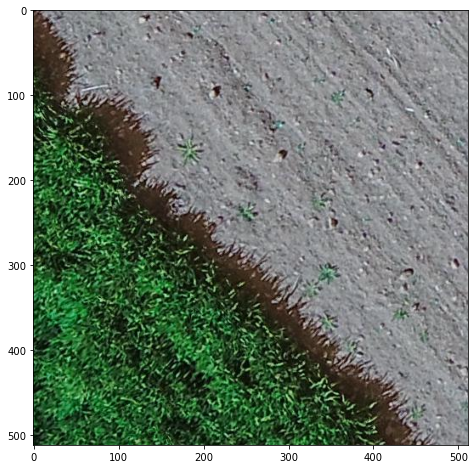

In [6]:
demo_test_img = 'repa_trn_23_4598958_2920949_png.rf.996ba731acd8b0d4b75c57acf85cc91b.jpg'
demo_test_img_path = os.path.join(f'{DIR_TRAIN}',demo_test_img)

# read image
demo_read_test_img = cv2.imread(demo_test_img_path, cv2.IMREAD_COLOR)
# display demo test image
fig_demo_test_img, ax_demo_test_img = plt.subplots(1, 1, figsize=(16, 8))
ax_demo_test_img.imshow(demo_read_test_img)

#### Show bounding boxes on original image

Number of boxes for demo image  14


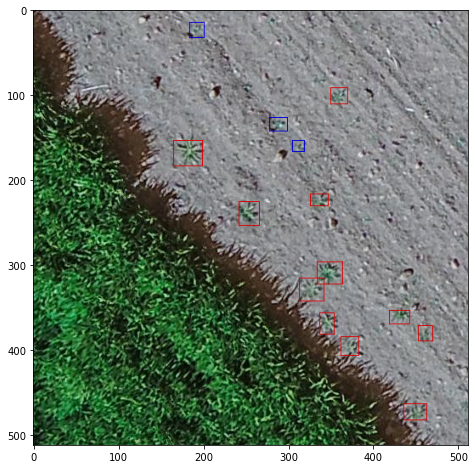

In [7]:
# colors for boxes. To my under standing 1 is weed, 2 is non-weed
colour_dict = {1:(220, 0, 0), 2:(0, 0, 220)}

# get number of boxes present in image.
demo_img_boxes_info = train_df[train_df["image_id"] == demo_test_img]
print('Number of boxes for demo image ', len(demo_img_boxes_info))

for index, row in demo_img_boxes_info.iterrows():
  if (row['class'] == 1 or row['class'] == 2):

    H = int(row['h'])
    W = int(row['w'])
    X = int(row['x'])
    Y = int(row['y'])
    cropped_image = demo_read_test_img[Y:Y+H, X:X+W]
    cv2.rectangle(demo_read_test_img, (X, Y), (X+W, Y+H), colour_dict[row['class']], 1)
    

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(demo_read_test_img)

#### Train data info
Train data information and test image information 

In [8]:
train_df.head()

,image_id,width,height,class,x,y,w,h
0,repa_trn_23_4598962_2920951_png.rf.12e714223c5...,512,512,2,180.0,101.0,12.0,13.0
1,repa_trn_23_4598962_2920951_png.rf.12e714223c5...,512,512,1,200.0,103.0,17.0,12.0
2,repa_trn_23_4598962_2920951_png.rf.12e714223c5...,512,512,2,376.0,109.0,21.0,15.0
3,repa_trn_23_4598962_2920951_png.rf.12e714223c5...,512,512,2,474.0,109.0,21.0,20.0
4,repa_trn_23_4598962_2920951_png.rf.12e714223c5...,512,512,2,286.0,118.0,17.0,11.0


In [9]:
demo_img_details = train_df[train_df["image_id"] == demo_test_img]
# store bounding box
bb = []
class_type = []
for index, row in demo_img_details.iterrows():
    H = int(row['h'])
    W = int(row['w'])
    X = int(row['x'])
    Y = int(row['y'])
    bb.append([X,Y,W,H])
    class_type.append(int(row['class']))
    
print('Number of bounding box for test image: ', len(bb))
print('One of the bounding of test image box ', bb[0])

Number of bounding box for test image:  14
One of the bounding of test image box  [350, 91, 20, 19]


In [10]:
import sys
sys.path.insert(0, '..')
from python.image_rotation_utils import *

image_path = DIR_TRAIN
image_filename = 'repa_trn_23_4598958_2920949_png.rf.996ba731acd8b0d4b75c57acf85cc91b.jpg'
output_path = '../datasets/rotation-images/'
output_annotations_file = '../datasets/rotation-images/_annotations.csv'

image_rot_util = ImageRotationUtils(image_path, image_filename, output_path, output_annotations_file)
# for 512 * 512 image scaling factor is 0.7079 so center of rotated image is same as original image.
(result, rotated_image, new_bb) = image_rot_util.rotate_image_angle(-45, 0.7079, bb, class_type)
print('result is: ', result)

Image  ../datasets/rotation-images/repa_trn_23_4598958_2920949_png.rf.996ba731acd8b0d4b75c57acf85cc91b.jpgrotate-45.png  saved successfully.
result is:  True


In [11]:
DIR_ROTATION_IMGS_INPUT = '../datasets/rotation-images'
rota_images_df = pd.read_csv(f'{DIR_ROTATION_IMGS_INPUT}/_annotations.csv')
rota_images_df.head()

,image_id,poly_left_top_corner_X,poly_left_top_corner_Y,poly_left_bottom_corner_X,poly_left_bottom_corner_Y,poly_right_bottom_corner_X,poly_right_bottom_corner_Y,poly_right_top_corner_X,poly_right_top_corner_Y,class
0,repa_trn_23_4598958_2920949_png.rf.996ba731acd...,385.645271,220.460177,376.134614,229.970834,386.145832,239.982052,395.155928,229.970834,1
1,repa_trn_23_4598958_2920949_png.rf.996ba731acd...,332.085255,201.939424,324.076281,209.948398,334.588060,220.460177,340.094230,209.948398,2
2,repa_trn_23_4598958_2920949_png.rf.996ba731acd...,332.085255,228.969712,325.577964,235.477003,332.585816,242.484856,338.592547,235.477003,2
3,repa_trn_23_4598958_2920949_png.rf.996ba731acd...,262.006731,158.891187,246.989904,173.908014,264.008974,190.927084,277.023557,173.908014,1
4,repa_trn_23_4598958_2920949_png.rf.996ba731acd...,311.061698,271.016827,304.053845,278.024679,314.565624,288.536458,318.069550,278.024679,1


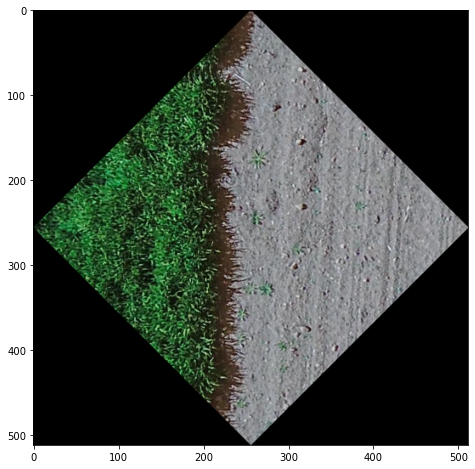

In [12]:
demo_rota_test_img = 'repa_trn_23_4598958_2920949_png.rf.996ba731acd8b0d4b75c57acf85cc91b.jpgrotate-45.png'
demo_rota_test_img_path = os.path.join(f'{DIR_ROTATION_IMGS_INPUT}',demo_rota_test_img)
# read image
demo_rota_read_test_img = cv2.imread(demo_rota_test_img_path, cv2.IMREAD_COLOR)
# display demo rotated test image output
fig_demo_rota_test_img, ax_demo_rota_test_img = plt.subplots(1, 1, figsize=(16, 8))
ax_demo_rota_test_img.imshow(demo_rota_read_test_img)

Number of boxes for rota demo image  14


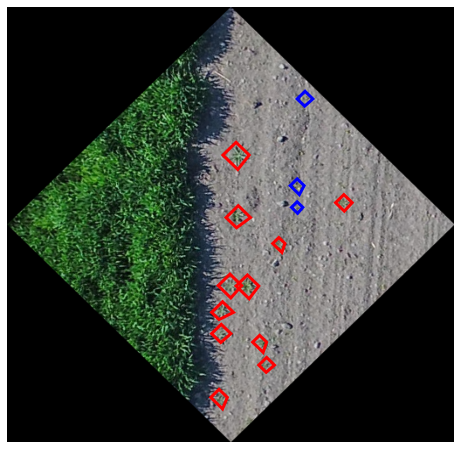

In [14]:

import matplotlib.patches as mpatches

# colors for boxes. To my under standing 1 is weed, 2 is non-weed
demo_rot_colour_dict = {1:'red', 2:'blue'}


# get number of boxes present in image.
demo_rota_img_boxes_info = rota_images_df[rota_images_df['image_id'] == demo_rota_test_img]
print('Number of boxes for rota demo image ', len(demo_rota_img_boxes_info))

# display demo rotated test image output with bounded boxes
fig_demo_bb_rota_test_img, ax_demo_bb_rota_test_img = plt.subplots(1, 1, figsize=(8, 8))
ax_demo_bb_rota_test_img.imshow(demo_rota_read_test_img[...,::-1], aspect='auto')
ax_demo_bb_rota_test_img.axis('off')

for index, row in demo_rota_img_boxes_info.iterrows():
  if (row['class'] == 1 or row['class'] == 2):
    
    left_top_corner = (float(row['poly_left_top_corner_X']), float(row['poly_left_top_corner_Y']))
    left_bottom_corner = (float(row['poly_left_bottom_corner_X']), float(row['poly_left_bottom_corner_Y']))
    right_bottom_corner = (float(row['poly_right_bottom_corner_X']), float(row['poly_right_bottom_corner_Y']))
    right_top_corner    = (float(row['poly_right_top_corner_X']), float(row['poly_right_top_corner_Y']))
    rotated_corners = np.array([left_top_corner, left_bottom_corner,  right_bottom_corner, right_top_corner])
    ax_demo_bb_rota_test_img.add_patch(mpatches.Polygon(rotated_corners,lw=3.0, fill=False, color=demo_rot_colour_dict[row['class']]))
   
